In [ ]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [2]:
# from phi.jax.stax.flow import * 
# from phi.tf.flow import *
# import phi
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from phi.jax.stax.flow import *

CUDA backend failed to initialize: Found cuDNN version 8100, but JAX was built against version 8600, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-11-07 15:20:13.535992: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 15:20:13.866793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-07 15:20:13.866838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-07 15:20:13

## 1D poisson Finite Difference

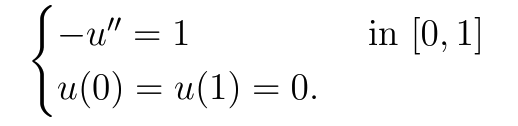

In [16]:
N = 20
x_np = jnp.linspace(0, 1, N)
f = -jnp.ones(100)

# Initialise u
u = jnp.zeros((N,1))

# Work out matrix A
A = jnp.zeros((N-2,N-2))
for i in range(len(A)):
    A = A.at[i,i].set(-2)
for i in range(len(A)-1):
    A = A.at[i,i+1].set(1)
for i in range(1,len(A)):
    A = A.at[i,i-1].set(1)
A = A / ((1/(N-1))**2)

In [17]:
# Define f_inside as the f values excluding boundaries
f_inside = jnp.reshape(f[1:N-1],(-1,1))

In [18]:
# Au = f (excluding boundaries)
u = u.at[1:N-1].set(jnp.matmul(jnp.linalg.inv(A),f_inside))

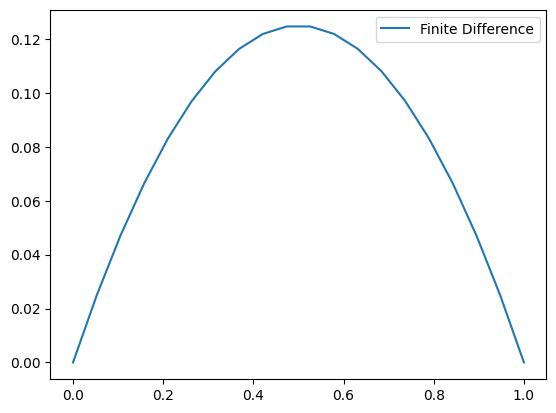

In [19]:
u_exact = 0.5 * (x_np-x_np**2)
# plt.plot(x_np,u_exact,label='Exact Solution')
plt.plot(x_np,u,label="Finite Difference")
plt.legend()
plt.show()

## Add Gaussian Process

In [80]:
def gaussian_kernal(x1,x2,l,sigma):
    m, n = x1.shape[0],x2.shape[0]
    dist_matrix = jnp.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix = dist_matrix.at[i,j].set(jnp.sum(x1[i]-x2[j])**2)
    return sigma ** 2 * jnp.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m = f_inside
G = gaussian_kernal(x_np[1:N-1],x_np[1:N-1],0.4,0.1)

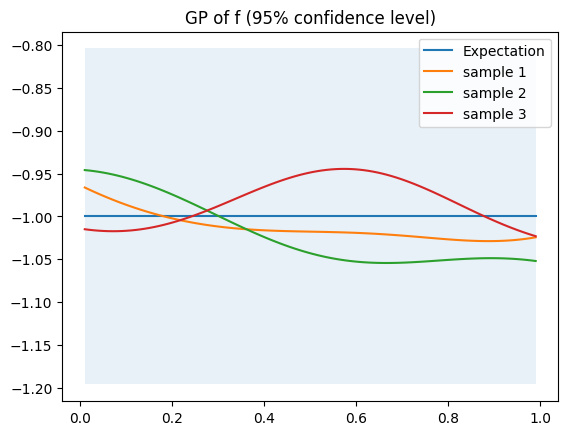

In [81]:
uncertainty = 1.96 * jnp.sqrt(jnp.diag(G))
plt.fill_between(x_np[1:99],m.ravel()+uncertainty,m.ravel()-uncertainty,alpha=0.1)
plt.plot(x_np[1:99],m.ravel(),label='Expectation')
plt.plot(x_np[1:99],np.random.multivariate_normal(m.ravel(),G),label='sample 1')
plt.plot(x_np[1:99],np.random.multivariate_normal(m.ravel(),G),label='sample 2')
plt.plot(x_np[1:99],np.random.multivariate_normal(m.ravel(),G),label='sample 3')
plt.title('GP of f (95% confidence level)')
plt.legend()
plt.show()

In [82]:
# Mean and covariance matrix of u
mean_u = jnp.matmul(jnp.linalg.inv(A),m)
covariance_u = jnp.matmul(jnp.matmul(jnp.linalg.inv(A),G),jnp.linalg.inv(A).T)

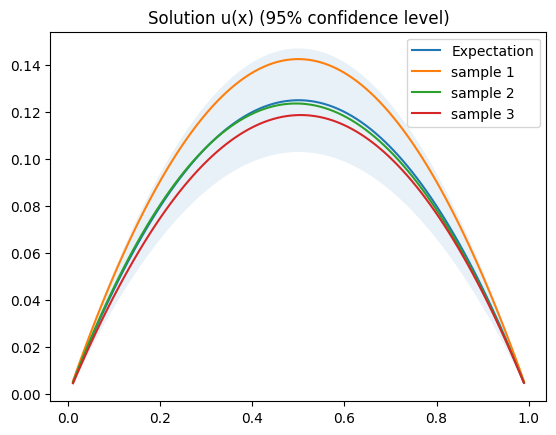

In [83]:
uncertainty = 1.96 * jnp.sqrt(jnp.diag(covariance_u))
plt.fill_between(x_np[1:99],mean_u.ravel()+uncertainty,mean_u.ravel()-uncertainty,alpha=0.1)
plt.plot(x_np[1:99],mean_u.ravel(),label='Expectation')
plt.plot(x_np[1:99],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 1')
plt.plot(x_np[1:99],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 2')
plt.plot(x_np[1:99],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 3')
plt.title('Solution u(x) (95% confidence level)')
plt.legend()
plt.show()

## Solve 1D Poisson with FEM

### Derivation

![image.png](/home/pz281@ad.eng.cam.ac.uk/mnt/data/WechatIMG92400.jpg)

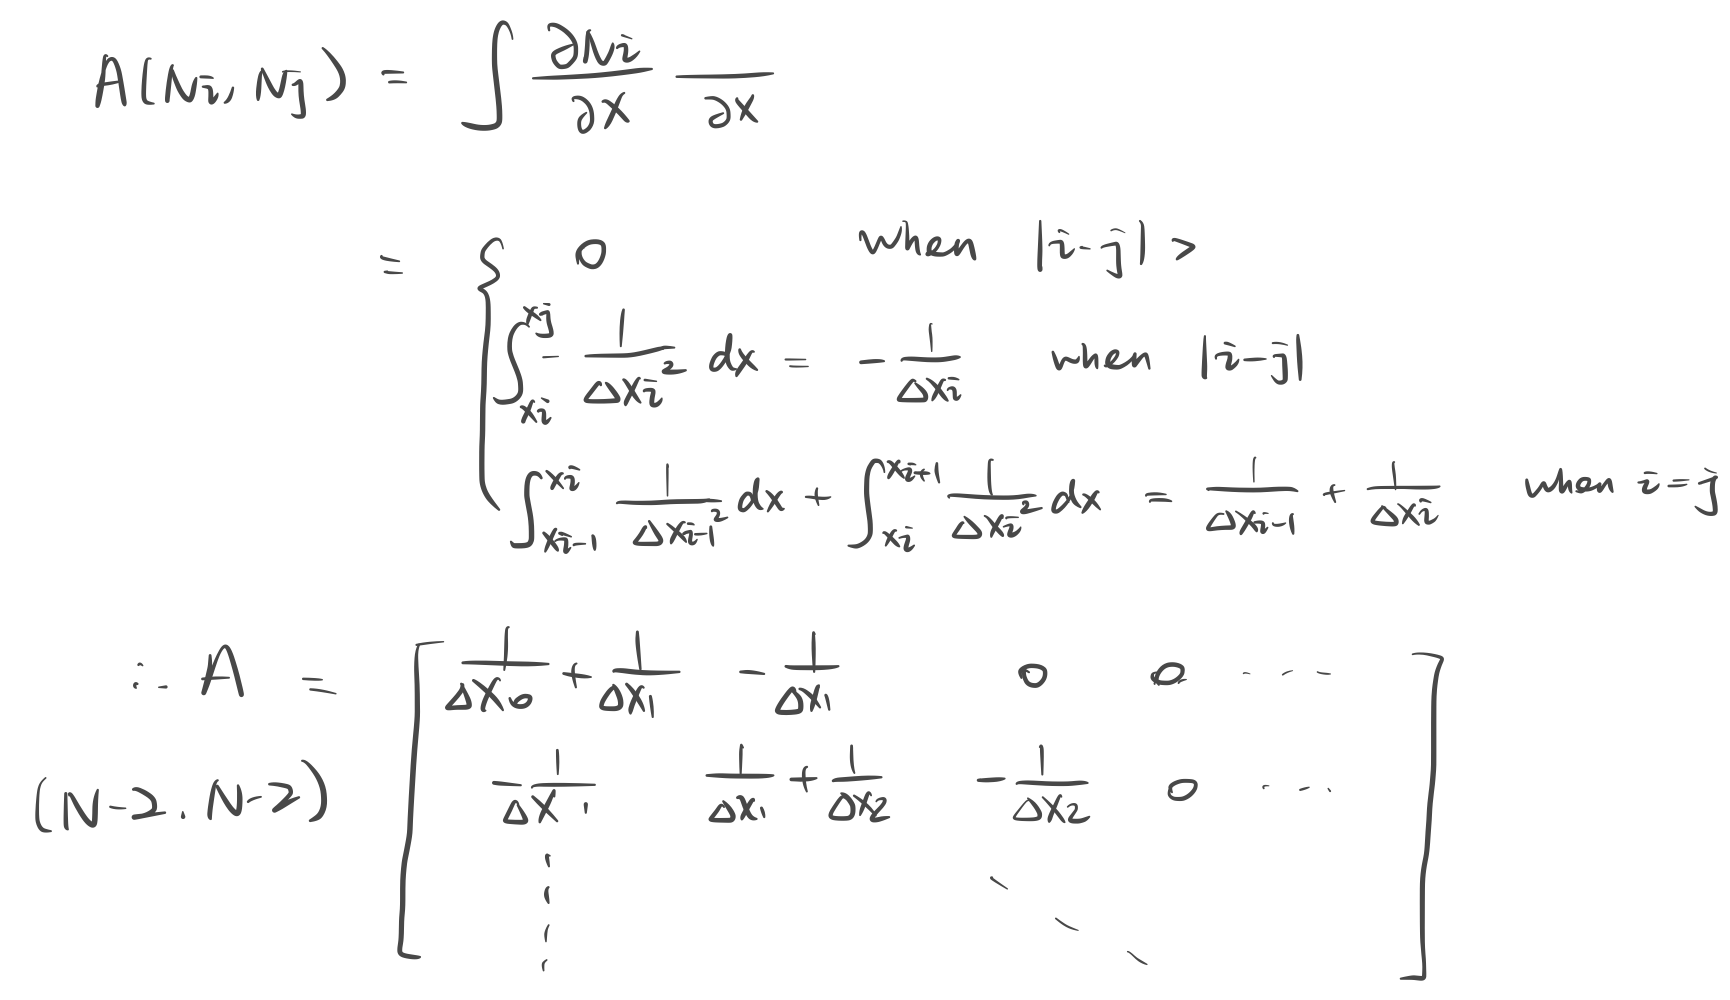

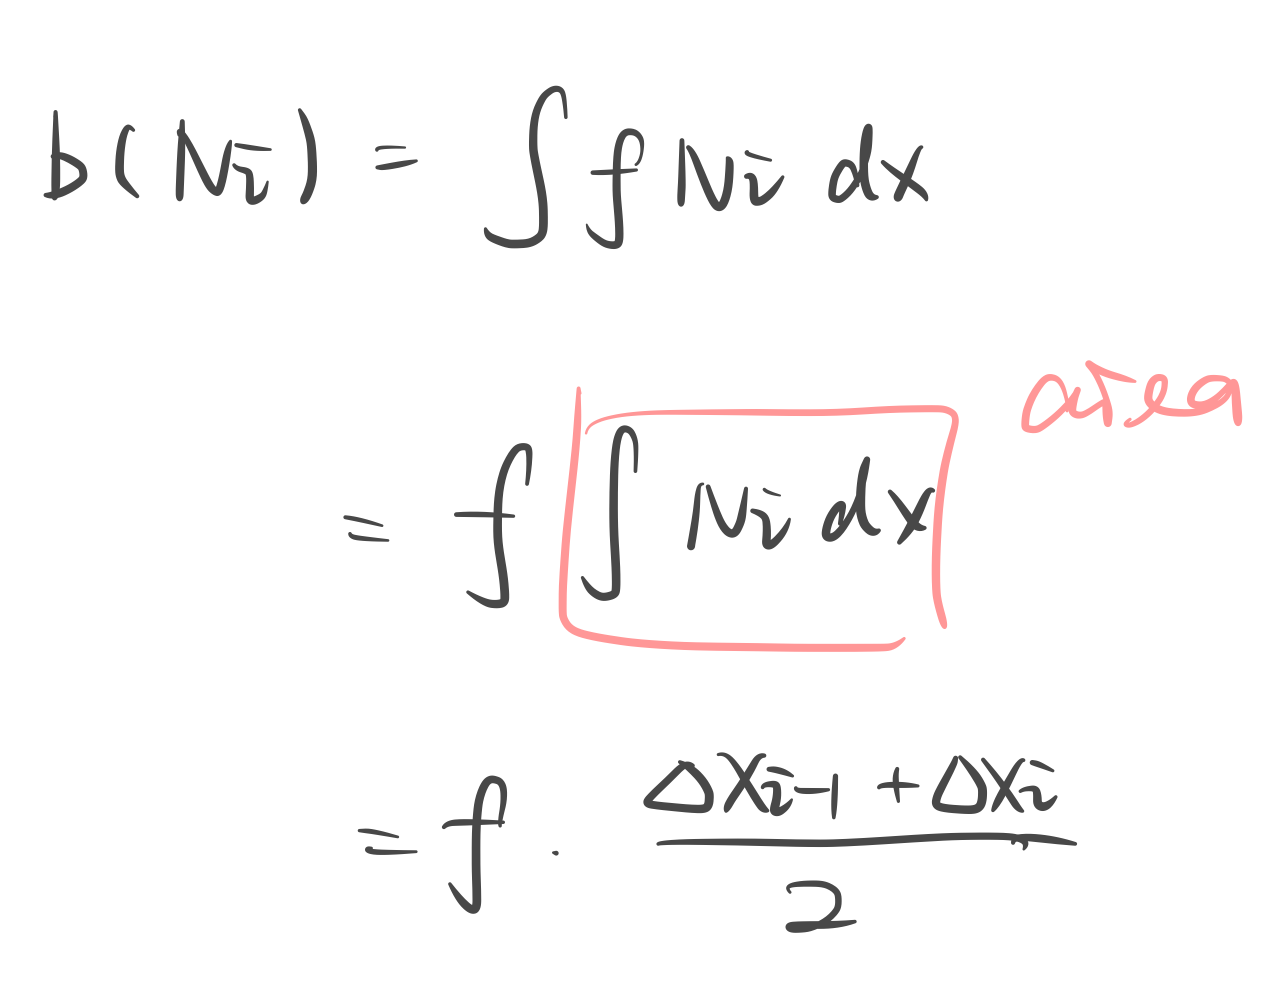

### Code

In [4]:
N = 20
x = jnp.linspace(0, 1, N)
dx = []
for i in range(N-1):
    dx.append(x[i+1]-x[i])

In [5]:
# Define matrix A
A = jnp.zeros((N-2,N-2))
for i in range(N-2):
    A = A.at[i,i].set((1/dx[i])+(1/dx[i+1]))
    
for i in range(N-3):
    A = A.at[i,i+1].set(-1/dx[i+1])
    
for i in range(N-3):
    A = A.at[i+1,i].set(-1/dx[i+1])

In [6]:
# Define b
b = jnp.zeros(N-2)
for i in range(N-2):
    b = b.at[i].set((dx[i]+dx[i+1])/2)
b = jnp.reshape(b, (-1,1))

In [7]:
# Calculate U via AU = b
U = jnp.matmul(jnp.linalg.inv(A),b)

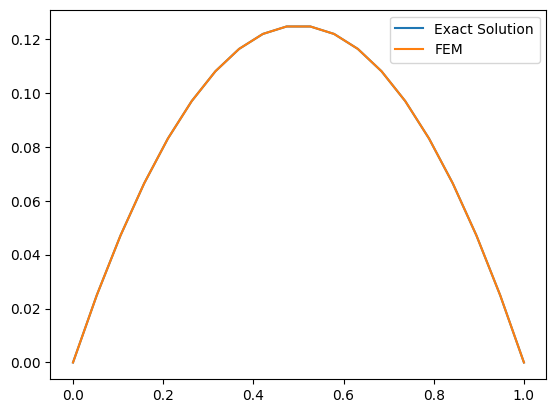

In [8]:
U_solution = jnp.zeros((N,1))
U_solution = U_solution.at[1:N-1].set(U)
u_exact = 0.5 * (x-x**2)
plt.plot(x,u_exact,label='Exact Solution')
plt.plot(x,U_solution,label="FEM")
plt.legend()

## Solve with FEM + GP

In [10]:
def gaussian_kernal(x1,x2,l,sigma):
    m, n = x1.shape[0],x2.shape[0]
    dist_matrix = jnp.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix = dist_matrix.at[i,j].set(jnp.sum(x1[i]-x2[j])**2)
    return sigma ** 2 * jnp.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
f = jnp.ones((N-2,1))
m = f
G = gaussian_kernal(x[1:N-1],x[1:N-1],0.4,0.1)

In [11]:
# Mean and covariance matrix of u
mean_u = jnp.matmul(jnp.linalg.inv(A),m)
covariance_u = jnp.matmul(jnp.matmul(jnp.linalg.inv(A),G),jnp.linalg.inv(A).T)

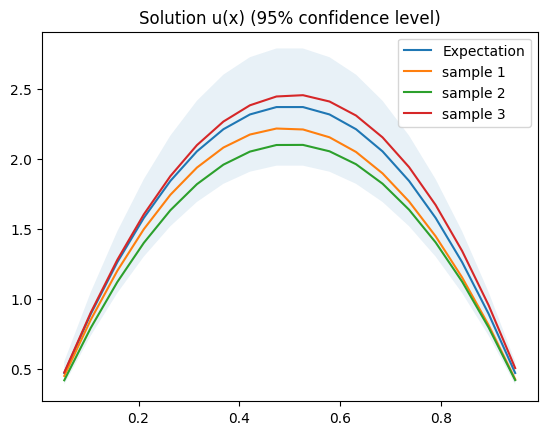

In [12]:
uncertainty = 1.96 * jnp.sqrt(jnp.diag(covariance_u))
plt.fill_between(x[1:N-1],mean_u.ravel()+uncertainty,mean_u.ravel()-uncertainty,alpha=0.1)
plt.plot(x[1:N-1],mean_u.ravel(),label='Expectation')
plt.plot(x[1:N-1],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 1')
plt.plot(x[1:N-1],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 2')
plt.plot(x[1:N-1],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 3')
plt.title('Solution u(x) (95% confidence level)')
plt.legend()
plt.show()